# Mass Spectrum Analysis

When performing a bake-out of a vacuum chamber, or when investigating an anomalously high vacuum pressure, we often take RGA (residual gas analyzer) mass spectra to determine the composition of the gas. Here, I present the usage of some code that I wrote to analyze and present these mass spectra.

In [6]:
import sys
sys.path.append('./code')
sys.path.append('../DatabaseAccess/code')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')
from mass_spectra import MassSpectrumLibrary, MassSpectrum
from database_access import DatabaseAccess
import pandas as pd
import numpy as np

### Creating a Mass Spectrum Library

I have obtained a series of `.jdk` files which are specialized NIST format for Mass Spectrum data. These can be obtained from this [NIST Database](http://www.nist.gov/srd/nist1a.cfm). I downloaded an array of these that i thought might be useful and stored them in the path `./library/`. I created the class `MassSpectrumLibrary` which reads in the `.jdk` files from this path and parses the data into usable formats in a dictionary. There is a `plot` function to visualize the mass spectra:

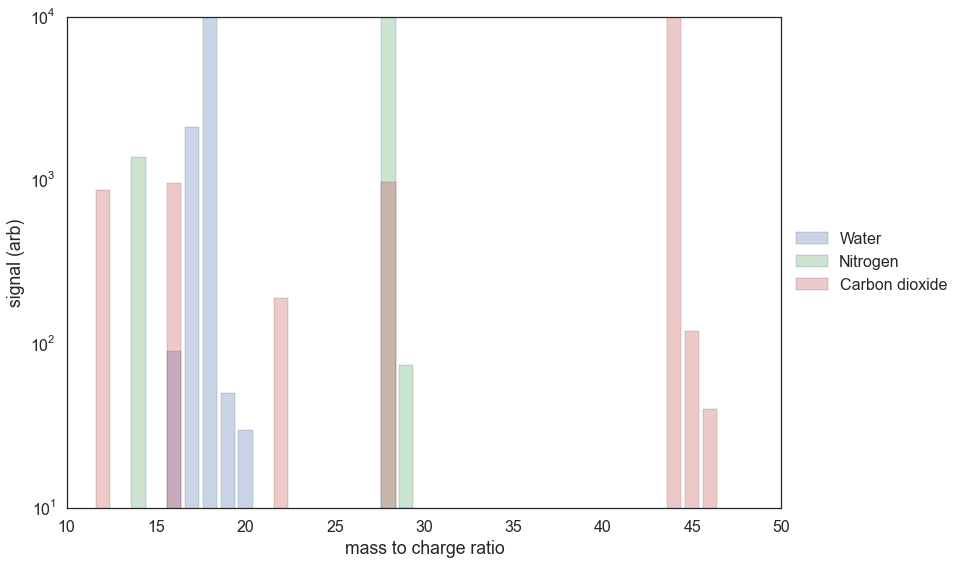

In [2]:
path = './library/'
lib = MassSpectrumLibrary(path)
lib.plot(['Water','Nitrogen','Carbon dioxide'])

We may also perform a quick look-up of which compounds in the database have peaks at a series of mass locations. Here, while baking we observed some mysterious peaks at 149 and 279 that are attributable to phthalates.

Here, the *match metric* is the fraction of the spectrum (accounting for intensity) that is attributable to the input peak locations. 

In [31]:
lib.search_for_peaks([149, 279])

,compound,match metric
0,Diisobutyl Phthalate,0.575699
1,Bis(2-ethylhexyl) phthalate,0.293291
2,"Cyclopentasiloxane, decamethyl-",0.000422


### Analyzing Spectra

The **ExTorr** RGA that we use saves the scan data in a particular `.xml` format. 
The class `MassSpectrum`:

- reads in a particular scan from file using `xmltodict`.
- performs background subtraction over a few mass units at the high end of the spectrum.
- evaluates the empirical lineshape averaged over all mass units (assuming it doesn't change with mass).
- fits to that lineshape to obtain the amplitudes with errorbars obtained from the goodness of fit.
- identifies peaks that are distinguishable from the background with $p>.05$ taking into account multiple hypothesis testing, assuming a normally distributed background signal.
- performs linear regression with respect to the input `library` of mass spectra.
- it trims the library mass spectra model of any components that result in amplitudes that are not significantly different from 0, and then iterates the linear regression model until all coefficients are statistically significantly different from zero.
- the method `print_report` enables visualization and saving of the mass spectrum, the empirical fit, and the library fit
- the method `peak_assignments` builds a table indicating which model components contribute most to any given detected peak in the spectrum.

Here are several mass spectra. The first one was taken immediately before baking the vacuum chamber during which the primary gas components are air. The following ones were taken during baking in which there appears to be a large phthalate signal.

According to [NASA](http://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19720020495.pdf) and [Agilent](https://www.agilent.com/cs/library/Support/Documents/FAQ232%20F05001.pdf), Phthalates are commonly found on gloves. Agilent additionally claims that phthalates can be a sign of o-rings damaged by high temperature.




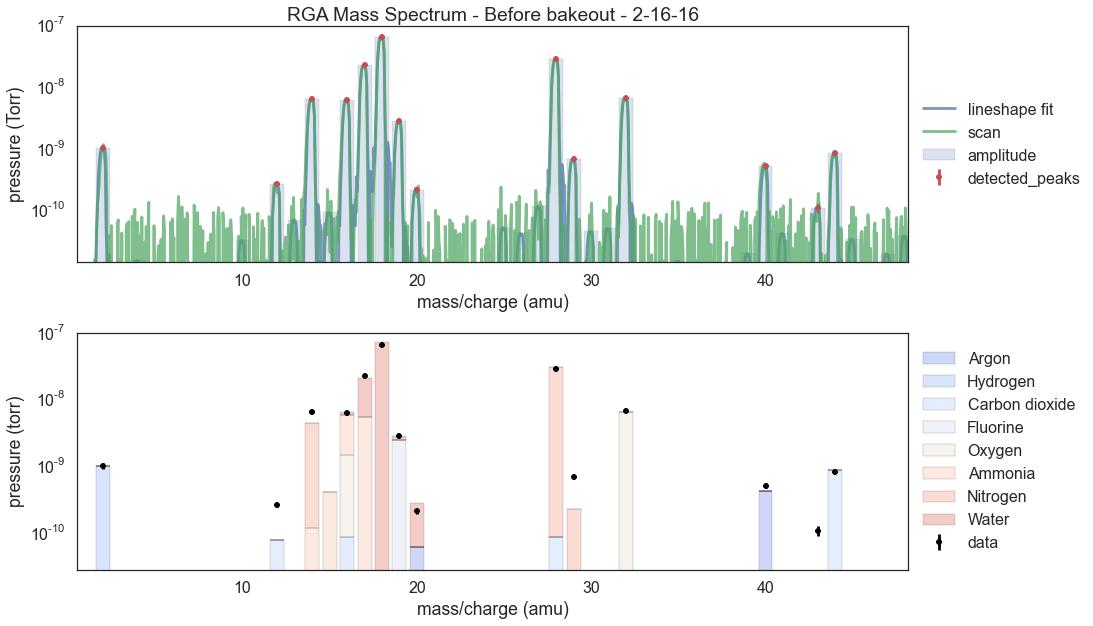

In [32]:
path = './data/Before bakeout - 2-16-16.xml'
ms0 = MassSpectrum(path, library=lib)
ms0.print_report()

here are peak assignments for the first spectrum:

In [33]:
ms0.peak_assignments()

,mass (amu),model error (%),pressure (torr),primary component,secondary component
0,2,0.000000,1.011228e-09,Hydrogen,None
1,12,70.532088,2.658652e-10,Carbon dioxide,None
2,14,32.085295,6.513537e-09,Nitrogen,Ammonia
3,16,4.360963,6.245306e-09,Ammonia,Oxygen
4,17,7.453065,2.251477e-08,Water,Ammonia
5,18,9.505302,6.623716e-08,Water,Ammonia
6,19,0.000000,2.841120e-09,Fluorine,Water
7,20,31.189651,2.132340e-10,Water,Argon
8,28,8.699143,2.879003e-08,Nitrogen,Carbon dioxide
9,29,66.122792,6.843805e-10,Nitrogen,Carbon dioxide


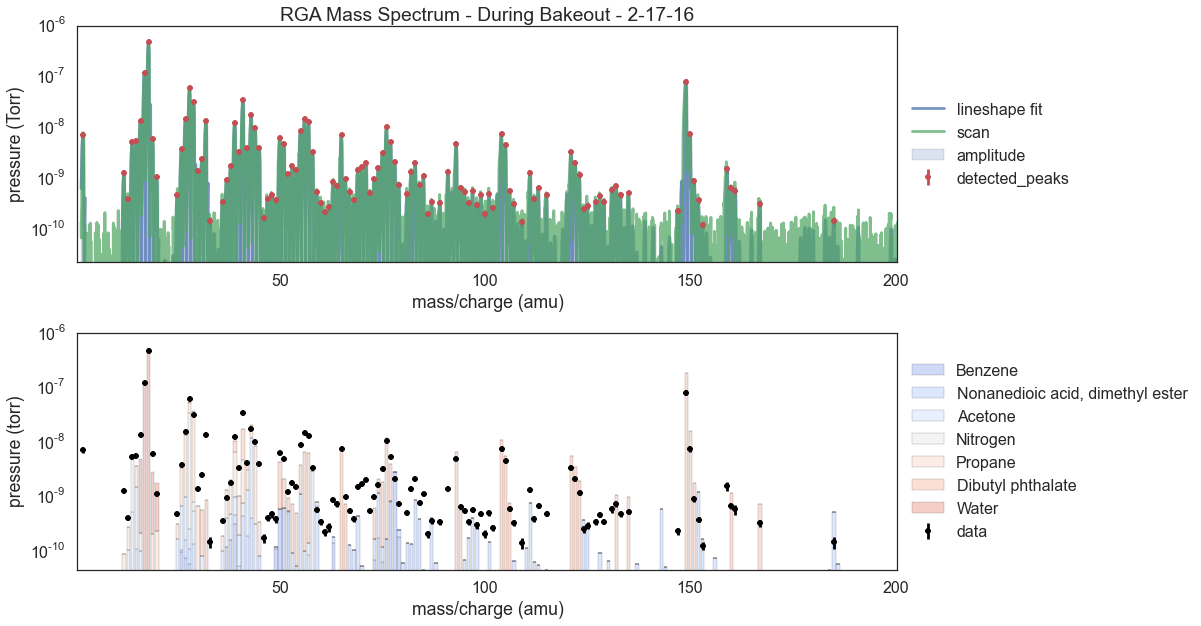

In [34]:
path = './data/During Bakeout - 2-17-16.xml'
ms1 = MassSpectrum(path, library=lib)
ms1.print_report()

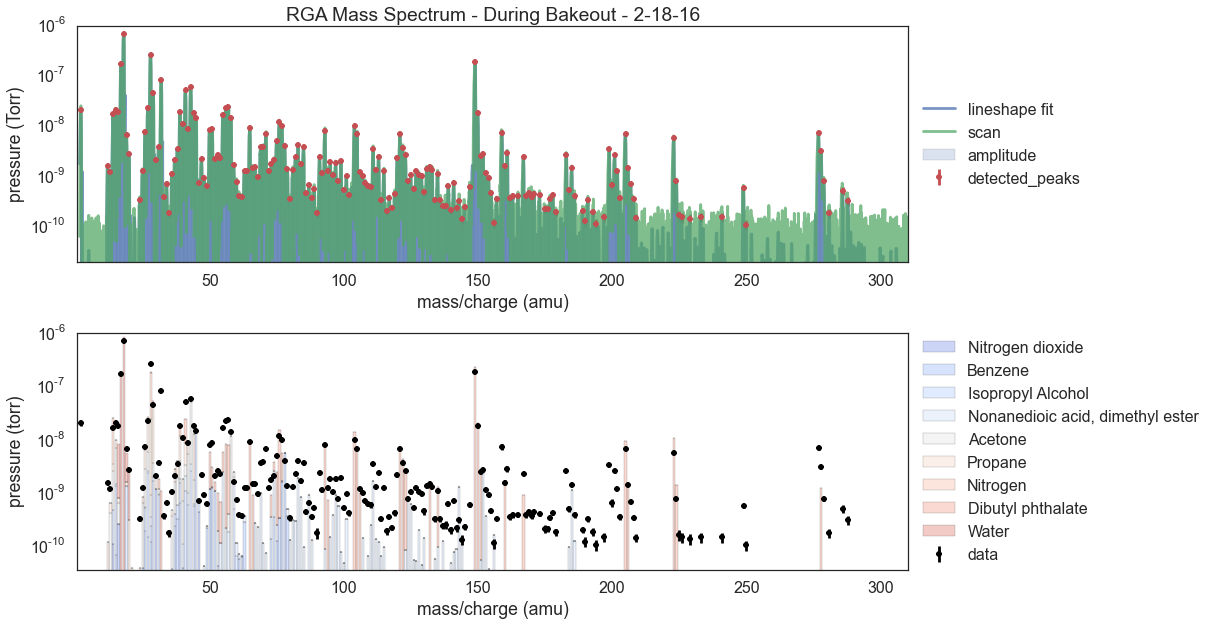

In [35]:
path = './data/During Bakeout - 2-18-16.xml'
ms2 = MassSpectrum(path, library=lib)
ms2.print_report()

Here are all of the largest 10 peaks that are dominated by Dibutyl phthalate:

In [36]:
table = ms2.peak_assignments()
DBP = table[table['primary component'] == 'Dibutyl phthalate']
DBP.sort_values('pressure (torr)', ascending=False).head(10)

,mass (amu),model error (%),pressure (torr),primary component,secondary component
132,149,23.571137,1.884290e-07,Dibutyl phthalate,None
18,32,98.613843,8.083281e-08,Dibutyl phthalate,"Nonanedioic acid, dimethyl ester"
27,41,52.125320,5.086059e-08,Dibutyl phthalate,Propane
43,57,65.352442,2.335627e-08,Dibutyl phthalate,Acetone
42,56,62.483562,2.237921e-08,Dibutyl phthalate,"Nonanedioic acid, dimethyl ester"
133,150,16.236565,1.771463e-08,Dibutyl phthalate,"Nonanedioic acid, dimethyl ester"
41,55,64.797062,1.666467e-08,Dibutyl phthalate,"Nonanedioic acid, dimethyl ester"
62,76,28.872992,1.190798e-08,Dibutyl phthalate,Benzene
63,77,43.425691,9.913546e-09,Dibutyl phthalate,Benzene
89,104,41.023641,9.692916e-09,Dibutyl phthalate,None


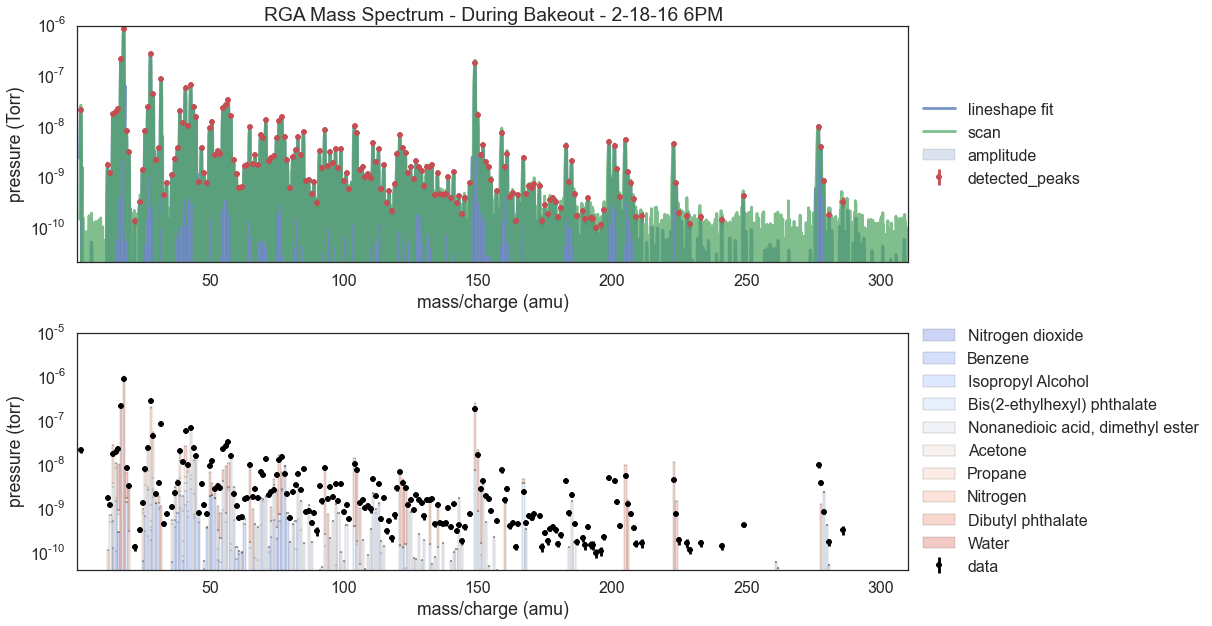

In [41]:
path = './data/During Bakeout - 2-18-16 6PM.xml'
ms3 = MassSpectrum(path, library=lib)
ms3.print_report()

In [45]:
table = pd.DataFrame({'compound':ms2.fit.coefficient_names,
                     'partial pressure (torr)': ms2.fit.coefficients,
                     'uncertainty (torr)': ms2.fit.dcoefficients})
table.sort_values(by='partial pressure (torr)', ascending=False)

,compound,partial pressure (torr),uncertainty (torr)
5,Water,1.294992e-06,1.509407e-07
3,Dibutyl phthalate,4.518523e-07,4.953464e-08
8,Nitrogen,1.989874e-07,3.457373e-08
2,Propane,1.263143e-07,2.292339e-08
9,Acetone,1.075452e-07,1.647714e-08
6,"Nonanedioic acid, dimethyl ester",4.360877e-08,5.809464e-09
1,Bis(2-ethylhexyl) phthalate,3.432556e-08,8.787702e-09
7,Isopropyl Alcohol,3.142603e-08,6.876987e-09
0,Benzene,2.382960e-08,4.788087e-09
4,Nitrogen dioxide,2.285878e-09,7.377917e-10


C:\Anaconda\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
./code\mass_spectra.py:433: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  coefficients = coefficients.sort('value')
C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


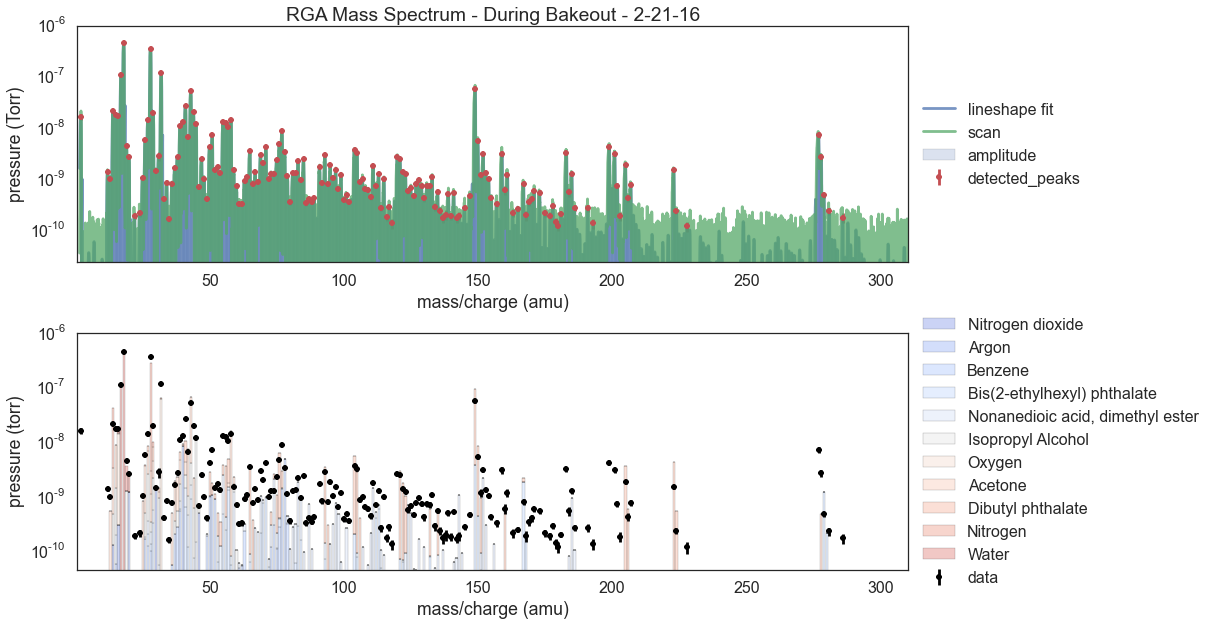

In [3]:
path = './data/During Bakeout - 2-21-16.xml'
ms4 = MassSpectrum(path, library=lib)
ms4.print_report()

Here is the vacuum chamber pressure in the interaction region during the bake-out procedure (accessed via the database). At the start on 2/16, we turn the temperature up slowly approaching 100 $^\circ$C, and the pressure rose to a few 10s of microtorr. The pressure decreased roughly exponentially with a time constant of 1-2 days. On 2/18 we turned up the vacuum chamber temperature to around 120 $^\circ$C with a corrsponding increase in pressure. On 2/21 we turn off the heating tape and observed an exponential decrease in the pressure in the vacuum chamber.

LoggingConfigSQL connection open
LoggingLogData connection open
database connection closed
saved: ./data/2016-02-16T10-52_2016-02-21T21-36_Dump_Region_Pressure.pkl


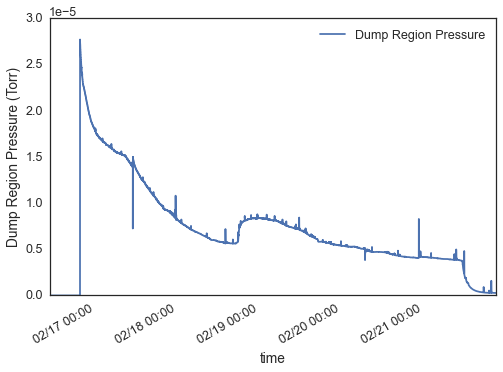

In [9]:
db = DatabaseAccess()
ts = db.get_data('Dump Region Pressure', duration='6 days')
ts.plot()
ts.save()

It might also be intersting to see if the baking significantly affected the room temperature in G14. It does look like there is a weak time delayed correlation between the vacuum chamber pressure and the ambient room temperature (with the temperature increasing from 20 to 23 degrees on 2/17 correlated with the interaction region temperature, and a corresponding decrease in temperature on 2/21 after turning of the heat.

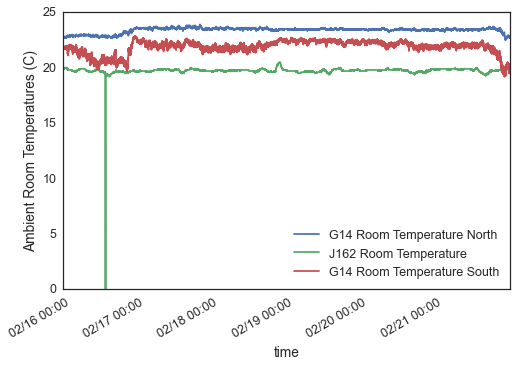

In [13]:
ts = db.get_data(group='Ambient Room Temperatures', duration='6 days')
ts.plot()
db.close()